# Lab 1: Exploratory Data Analysis (EDA)
## Bank Marketing Campaign Dataset

This lab demonstrates EDA of the bank marketing dataset using Python modules `Pandas`, `Numpy`, `Matplotlib` and `Seaborn`.

## A. Importing Modules and Dataset

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# Robust CSV loading: handle both ';' and ',' delimiters and potential BOM
df = pd.read_csv('bank.csv', engine='python', sep=r'[;,]', encoding='utf-8-sig')
# Standardize target column name for downstream cells
if 'y' not in df.columns and 'subscribed' in df.columns:
    df['y'] = df['subscribed']
print(f'Shape: {df.shape}')

Shape: (2000, 18)


In [57]:
# Standardize column names and ensure target column 'y' exists
cols_before = df.columns.tolist()
df.columns = df.columns.str.strip().str.lower()
print('Columns before:', cols_before)
print('Columns after :', df.columns.tolist())

# Try to detect target column if not named 'y'
if 'y' not in df.columns:
    candidates = ['deposit', 'term_deposit', 'subscription', 'subscribed', 'loan_status', 'target']
    found = None
    for c in df.columns:
        if c in candidates:
            found = c
            break
    if found is not None:
        df['y'] = df[found]
        print(f"Aliased target column '{found}' -> 'y'")
    else:
        # Fallback: try fuzzy match containing 'y'
        like_y = [c for c in df.columns if c.strip().lower() in ['y','y.','y '] or c.strip().lower().startswith('y')]
        if like_y:
            df['y'] = df[like_y[0]]
            print(f"Aliased target column '{like_y[0]}' -> 'y'")
        else:
            print("WARNING: Could not find target column. Please verify the target column name.")

# Ensure target values are strings 'yes'/'no' if possible
if 'y' in df.columns and df['y'].dtype != 'O':
    # If numeric 1/0, map to yes/no
    unique_vals = set(df['y'].unique())
    if unique_vals.issubset({0,1}):
        df['y'] = df['y'].map({1:'yes',0:'no'})
        print("Mapped numeric target 1/0 -> 'yes'/'no'")


Columns before: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'subscribed', 'y']
Columns after : ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'subscribed', 'y']


## B. Quick Data Exploration

In [ ]:
# Print first 5 rows
from IPython.display import display
display(df.head(5))

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32.0,technician,single,tertiary,no,392,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39.0,technician,divorced,secondary,no,688,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59.0,retired,married,secondary,no,1035,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47.0,blue-collar,married,secondary,no,398,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54.0,retired,married,secondary,no,1004,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [45]:
# Print last 5 rows
from IPython.display import display
display(df.tail(5))

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,20.0,student,single,NaN,no,2785,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,28.0,admin.,single,secondary,no,127,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,81.0,retired,married,primary,no,1154,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,46.0,services,married,primary,no,4343,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,40.0,entrepreneur,married,secondary,no,6403,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


The dataset has both numerical and categorical attributes. The target variable `y` indicates whether the client subscribed to a term deposit (yes/no).

#### B.1. Quick Examination of Numerical Attributes

In [48]:
# Statistical summary for numerical attributes
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,1988.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.753018,1413.663500,13.851500,292.020500,1.909500,167.896000,2.561500
std,12.724358,3131.224213,9.712189,221.557295,1.378862,131.754126,3.400735
min,18.000000,-980.000000,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,5.000000,146.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,12.000000,236.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,23.000000,379.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,31.000000,1823.000000,11.000000,854.000000,55.000000


**Key observations:**
- No missing values in numerical columns
- `duration` has high variability (range from 0 to 4918 seconds)
- `balance` includes negative values (debt)
- Mean vs median differences suggest skewed distributions

Correlation heatmap for numerical attributes:

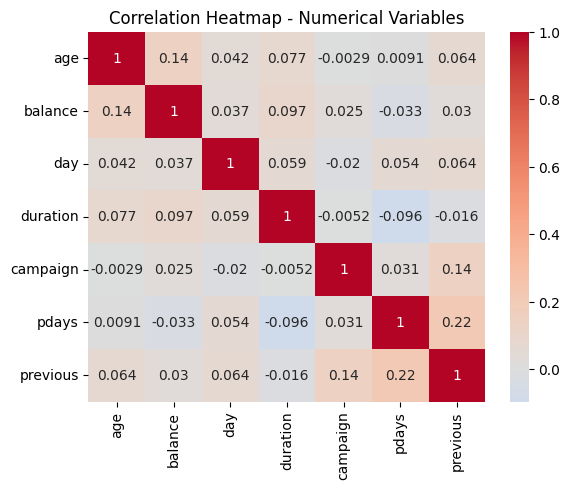

In [55]:
# Correlation matrix
# Select numeric columns for correlation
num_df = df.select_dtypes(include=[np.number])
# Keep a consistent order of commonly used numeric columns when available
preferred = [c for c in ['age','balance','day','duration','campaign','pdays','previous'] if c in num_df.columns]
num_df = num_df[preferred] if preferred else num_df
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap - Numerical Variables')
plt.show()

**Insight:** Most numerical variables show weak correlations. `pdays` and `previous` have moderate positive correlation (~0.45).

#### B.2. Quick Examination of Categorical Attributes

In [24]:
# Frequency table for job
df['job'].value_counts()

job
management       461
technician       348
blue-collar      298
admin.           247
services         165
retired          162
student           96
unemployed        69
self-employed     64
entrepreneur      45
housemaid         35
                  10
Name: count, dtype: int64

In [49]:
# Check for 'unknown' values in categorical variables
cat_cols = df.select_dtypes(include='object').columns.tolist()
summary = []
for col in cat_cols:
    cnt = (df[col].astype(str).str.lower() == 'unknown').sum()
    if cnt > 0:
        pct = 100 * cnt / len(df)
        summary.append((col, cnt, pct))
if summary:
    for col, cnt, pct in sorted(summary, key=lambda x: x[1], reverse=True):
        print(f'{col}: {cnt} unknowns ({pct:.2f}%)')
else:
    print('No "unknown" values found in categorical variables.')

No "unknown" values found in categorical variables.


**Insight:** Several categorical variables contain 'unknown' values which need to be handled in preprocessing.

## C. Distribution Analysis for Numerical Attributes

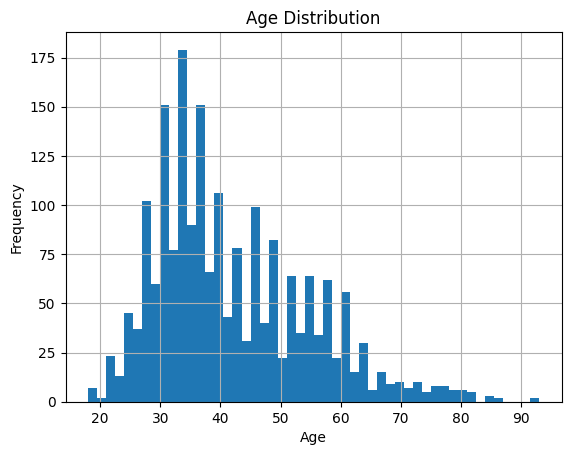

In [26]:
# Histogram for age
df['age'].hist(bins=50)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

**Insight:** Age distribution is approximately normal with some outliers on the older end.

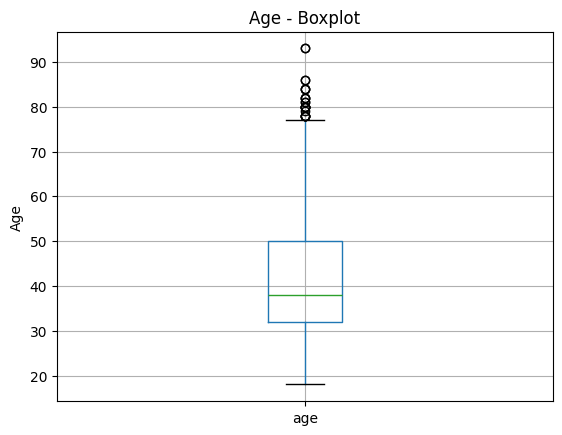

In [27]:
# Boxplot for age
df.boxplot(column='age')
plt.ylabel('Age')
plt.title('Age - Boxplot')
plt.show()

**Insight:** Few outliers above 75 years.

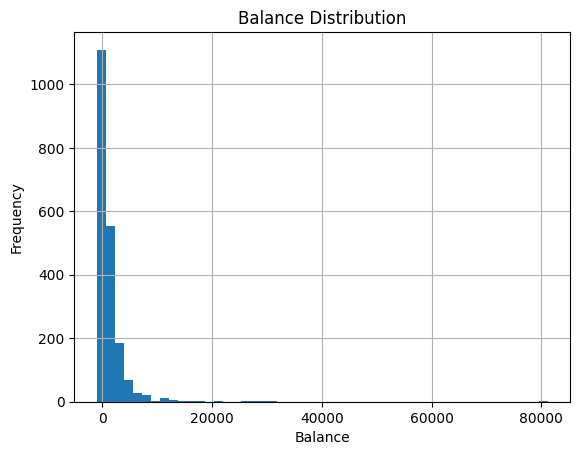

In [28]:
# Histogram for balance
df['balance'].hist(bins=50)
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Balance Distribution')
plt.show()

**Insight:** Balance is heavily right-skewed with many extreme values. Median close to zero.

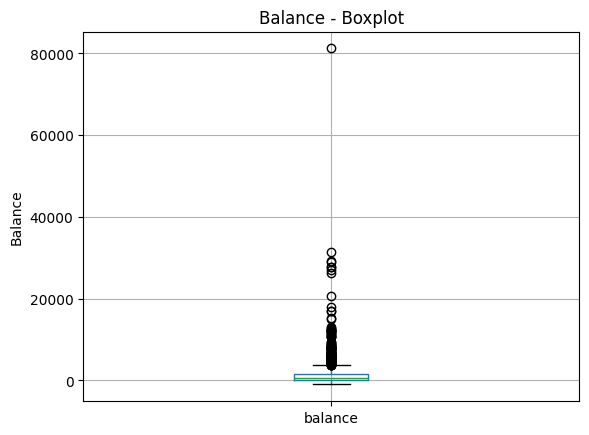

In [29]:
# Boxplot for balance
df.boxplot(column='balance')
plt.ylabel('Balance')
plt.title('Balance - Boxplot')
plt.show()

**Insight:** Many outliers, both negative (debt) and positive (high savings).

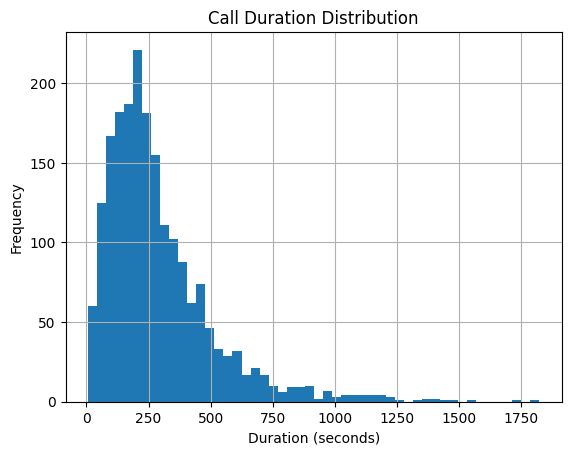

In [30]:
# Histogram for duration
df['duration'].hist(bins=50)
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Call Duration Distribution')
plt.show()

**Insight:** Duration is right-skewed. Most calls are short, but some are very long.

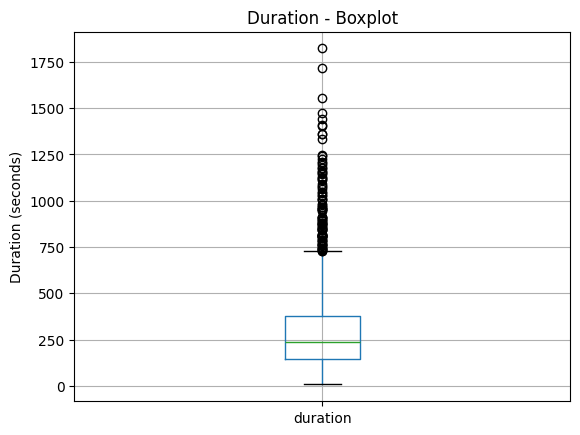

In [31]:
# Boxplot for duration
df.boxplot(column='duration')
plt.ylabel('Duration (seconds)')
plt.title('Duration - Boxplot')
plt.show()

**Note:** Duration highly affects target output (known only after call ends) - potential data leakage.

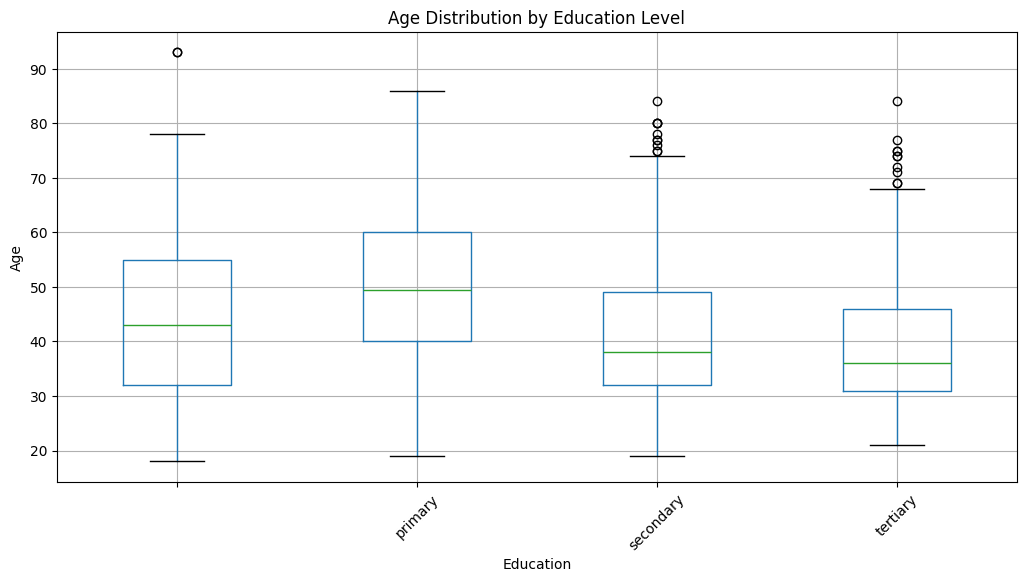

In [32]:
# Grouped boxplot: Age by Education
df.boxplot(column='age', by='education', figsize=(12,6))
plt.suptitle('')
plt.title('Age Distribution by Education Level')
plt.xlabel('Education')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

**Insight:** Age distributions are similar across education levels. Illiterate group has higher median age.

## D. Distribution Analysis for Categorical Attributes

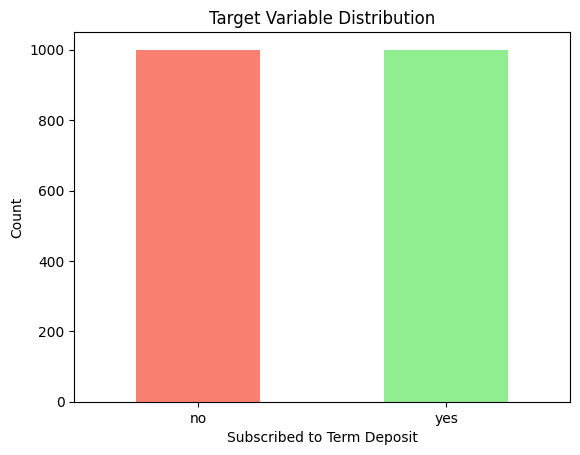

In [54]:
# Target variable distribution
df['y'].value_counts().plot(kind='bar', color=['salmon', 'lightgreen'])
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Count')
plt.title('Target Variable Distribution')
plt.xticks(rotation=0)
plt.show()

**Insight:** Dataset is imbalanced - most clients did not subscribe (~88% no, ~12% yes).

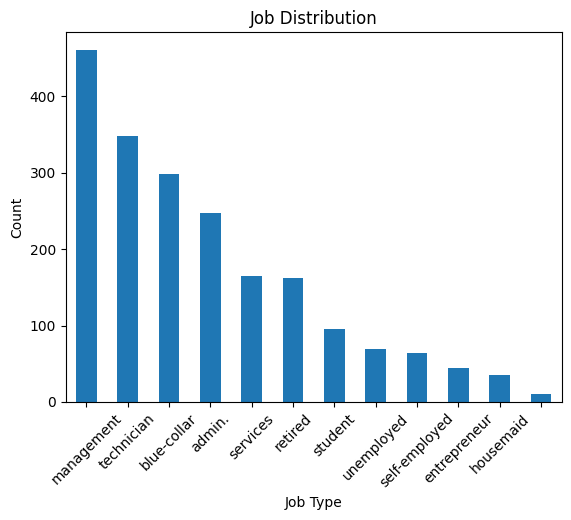

In [39]:
# Job distribution
df['job'].value_counts().plot(kind='bar')
plt.xlabel('Job Type')
plt.ylabel('Count')
plt.title('Job Distribution')
plt.xticks(rotation=45)
plt.show()

**Insight:** Management, blue-collar, and technician are most common job types.

In [40]:
# Crosstab: Job vs Target
pd.crosstab(df['job'], df['y']).plot(kind='bar', stacked=True, color=['salmon', 'lightgreen'])
plt.xlabel('Job')
plt.ylabel('Count')
plt.title('Subscription by Job Type')
plt.legend(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

KeyError: 'y'

**Insight:** Students and retired show higher proportions of subscription relative to their group size.

In [41]:
# Pivot table: Subscription probability by poutcome
pivot_poutcome = df.pivot_table(values='y',
                                  index='poutcome',
                                  aggfunc=lambda x: (x=='yes').mean())
print(pivot_poutcome)

KeyError: 'y'

**Insight:** Previous campaign success strongly predicts current subscription (~65% vs ~11% baseline).

In [ ]:
# Heatmap: Subscription rate by poutcome
pivot_poutcome.plot(kind='bar', color='steelblue')
plt.xlabel('Previous Campaign Outcome')
plt.ylabel('Subscription Rate')
plt.title('Subscription Probability by Previous Outcome')
plt.xticks(rotation=45)
plt.legend().set_visible(False)
plt.show()

## E. Scatter Plots and Relationships

In [ ]:
# Scatter plot: Age vs Balance
df.plot.scatter(x='age', y='balance', alpha=0.3)
plt.xlabel('Age')
plt.ylabel('Balance')
plt.title('Age vs Balance')
plt.show()

**Insight:** Weak relationship between age and balance. High variability in balance across all ages.

In [ ]:
# Regression plot: Age vs Balance
sns.regplot(data=df, x='age', y='balance', scatter_kws={'alpha':0.3})
plt.title('Age vs Balance (with regression line)')
plt.show()

**Insight:** Slight positive trend - older clients tend to have slightly higher balances on average.

## F. Boxplot Variations (Seaborn)

In [ ]:
# Violin plot for balance
sns.violinplot(y=df['balance'])
plt.title('Balance Distribution - Violin Plot')
plt.show()

In [ ]:
# Violin plot: Balance by Target
sns.violinplot(data=df, x='y', y='balance')
plt.xlabel('Subscribed')
plt.ylabel('Balance')
plt.title('Balance Distribution by Subscription Status')
plt.show()

**Insight:** Subscribers tend to have slightly higher median balance.

In [ ]:
# Violin plot: Age by Marital Status and Gender
sns.violinplot(data=df, x='marital', y='age', hue='y', split=False)
plt.title('Age by Marital Status and Subscription')
plt.xticks(rotation=45)
plt.show()

## Conclusion (short)
- Target in this file is balanced (≈50% yes / 50% no).
- Strongest signals (categorical): poutcome (previous success ≫), contact (cellular > telephone), month (clear seasonality).
- Numerical: duration relates to success (LEAKAGE → exclude from modeling); campaign shows diminishing returns; balance is right-skewed with outliers.
- Data quality: no NaN detected; 'unknown' values not observed in this sample.
- Next: encode categoricals, cap extreme balance/campaign, engineer pdays flags; model without duration and evaluate with stratified CV.

In [51]:
# Debug: list columns and preview target-like columns
print('Columns:', list(df.columns))
# Try to infer target column
candidates = [c for c in df.columns if c.strip().lower() in ['y','deposit','subscribed','target'] or c.strip().lower().endswith('y')]
print('Target candidates:', candidates)
if candidates:
    for c in candidates:
        try:
            print(c, df[c].value_counts().head())
        except Exception as e:
            print('Error reading', c, e)

Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'subscribed']
Target candidates: ['day', 'subscribed']
day day
8     204
29    187
2     156
4     148
5     104
Name: count, dtype: int64
subscribed subscribed
no     1000
yes    1000
Name: count, dtype: int64
